In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import yfinance as yf
import datetime

import warnings

import RECH_functions as RECH

import pickle

In [2]:
act_func = RECH.relu

In [4]:
my_list = ["MMM",
"AXP",
"AMGN",
"AAPL",
"BA",
"CAT",
"CVX",
"CSCO",
"KO",
"DOW",
"GS",
"HD",
"HON",
"INTC",
"IBM",
"JNJ",
"JPM",
"MCD",
"MRK",
"MSFT",
"NKE",
"PG",
"CRM",
"TRV",
"UNH",
"VZ",
"V",
"WBA",
"WMT",
"DIS",
"^GSPC"]
my_list.remove("DOW") # dow joined in 2019
my_list.sort()

In [7]:

vP0 = (0.1, 0.8, 0.1, 0.1 , 0.1, 0.1, 0.1, 0.1)
my_bounds = ((0.0001,1), (0.0001,1), (0.0001, 10),  (0.0001, 3) , (-10, 10), (-10, 10), (-10,10)  ,(-100,100 ))
par_names = ["alpha", "beta", "gamma0", "gamma1",  "v1",  "v2",  "w",  "b"]

def con(t):
    return (-1)*(t[0] + t[1]) + 0.99
cons = {'type':'ineq', 'fun': con}

df_pars = pd.DataFrame(columns = par_names, index = my_list)
forecast_all = pd.DataFrame()

mc_M = 5000

act_func = RECH.relu
warning_list = []

for symbol in my_list:
    pd_this_share = pd_this_share = pd.read_csv("data_ret.csv")
    is_list = [(pd_this_share.index[x] < datetime.date(2017, 1, 1)) for x in range(len(pd_this_share)) ]
    is_data = pd_this_share[is_list]
    is_data.drop(index=is_data.index[0], axis=0, inplace=True) # dropping the first value with NA in returns
    is_returns = is_data['log_ret * 100']
    print("####################")
    print(is_returns.head(4))
    print("####################")
    os_list = [(pd_this_share.index[x] >= datetime.date(2017, 1, 1)) for x in range(len(pd_this_share)) ]
    os_data = pd_this_share[os_list]
    os_returns = os_data['log_ret * 100']
    vP0 = (0.1, 0.8, 0.1, 0.1 , 0.1, 0.1, 0.1, 0.1)
    my_bounds = ((0.0001,1), (0.0001,1), (0.0001, 10),  (0.0001, 3) , (-5, 5), (-5, 5), (-5,5)  ,(-5,5 ))
    update_window = 20 # length of the updating window 20 -> monthly, 5 -> weekly
    sample_returns = is_returns # the sample returns serires keeps getting longer: after each iteration new informatuion is added
    os_decreasing = os_returns # out of sample returns, shrinking as sample increases
    forecasts_symbol = pd.DataFrame(index=os_data.index)
    horizons = (1, 5, 20)
    for p in range(len(horizons)):
        forecasts_symbol[symbol + f"_{horizons[p]}_h_sigma"] = np.zeros(len(os_returns))
        forecasts_symbol[symbol + f"_{horizons[p]}_h_omega"] = np.zeros(len(os_returns))
    #print(symbol + f"_{horizons[p]}_h")
    print(forecasts_symbol.columns)
    
    for i in range(int(len(os_returns)/update_window)):
        if i == 0:
            # different starting values for optimisation as well as for forecasting in the first iteration
            res_srn = opt.minimize(RECH.SRN_garch_loglike, vP0, args = (act_func, sample_returns),
                          bounds = my_bounds,
                           #method = "Nelder-Mead",
                            method = "SLSQP", 
                          options = {"disp": False, "maxiter": 100000},
                            constraints = cons)
            # sample returns contain all information up to t = t
            # mc forecast function uses the lastest return as information
            
            for k in range(update_window):
                """for every time (t+1), (t+2), ... there are 3 forecasts made with respective information
                (t+1)-h1, (t+1)-h2, (t+1)-h3, (t+2)-h1, ... """
                for horizon in horizons:
                    
                    fore_sig = RECH.mc_srn2(res_srn.x, act_func, sample_returns[:-horizon], mc_M, horizon)[0]
                    fore_om = RECH.mc_srn2(res_srn.x, act_func, sample_returns[:-horizon], mc_M, horizon)[1]
                    forecasts_symbol[symbol + f"_{horizon}_h_sigma"].iloc[i*update_window + k] = fore_sig
                    forecasts_symbol[symbol + f"_{horizon}_h_omega"].iloc[i*update_window + k] = fore_om
                    if fore_sig < 0:
                        warning_list.append(symbol)
                        warning_list.append(res_srn.x)
                ### now for every k the sample grows by 1
                sample_returns = sample_returns.append(os_decreasing.head(1))
                os_decreasing = os_decreasing.tail(-1)
            
                
        else:
            sample_returns = sample_returns.tail(-update_window)
            new_bounds = my_bounds
            res_srn = opt.minimize(RECH.SRN_garch_loglike, res_srn.x, args = (act_func, sample_returns),
                          bounds = new_bounds,
                           #method = "Nelder-Mead",
                            method = "SLSQP", 
                          options = {"disp": False, "maxiter": 30000},
                            constraints = cons)
            for k in range(update_window):
                """for every time (t+1), (t+2), ... there are 3 forecasts made with respective information
                (t+1)-h1, (t+1)-h2, (t+1)-h3, (t+2)-h1, ... """
                for horizon in horizons:
                    fore_sig = RECH.mc_srn2(res_srn.x, act_func, sample_returns[:-horizon], mc_M, horizon)[0]
                    fore_om = RECH.mc_srn2(res_srn.x, act_func, sample_returns[:-horizon], mc_M, horizon)[1]
                    forecasts_symbol[symbol + f"_{horizon}_h_sigma"].iloc[i*update_window + k] = fore_sig
                    forecasts_symbol[symbol + f"_{horizon}_h_omega"].iloc[i*update_window + k] = fore_om
                    if fore_sig < 0:
                        warning_list.append(symbol)
                        warning_list.append(res_srn.x)
                ### now for every k the sample grows by 1
                sample_returns = sample_returns.append(os_decreasing.head(1))
                os_decreasing = os_decreasing.tail(-1)
                #print(f"in sample: {len(sample_returns)}, out of sample: {len(os_decreasing)}")
            
    df_pars.iloc[my_list.index(symbol)] = res_srn.x        
    forecast_all = pd.concat([forecast_all, forecasts_symbol], axis=1)
    
with open('srn_warnings', 'wb') as fp:
    pickle.dump(warning_list, fp)

[*********************100%***********************]  1 of 1 completed
####################
Date
2005-01-04 00:00:00-05:00   -1.079981
2005-01-05 00:00:00-05:00   -0.207051
2005-01-06 00:00:00-05:00   -0.311357
2005-01-07 00:00:00-05:00   -0.437544
Name: log_ret * 100, dtype: float64
####################
Index(['IBM_1_h_sigma', 'IBM_1_h_omega', 'IBM_2_h_sigma', 'IBM_2_h_omega'], dtype='object')


In [10]:
forecast_all

,^GSPC_1_h_sigma,^GSPC_1_h_omega,^GSPC_2_h_sigma,^GSPC_2_h_omega,^GSPC_3_h_sigma,^GSPC_3_h_omega,IBM_1_h_sigma,IBM_1_h_omega,IBM_2_h_sigma,IBM_2_h_omega,IBM_3_h_sigma,IBM_3_h_omega
Date,,,,,,,,,,,,
2018-01-02 00:00:00-05:00,0.214201,0.040445,0.599605,0.040445,0.562070,0.040445,1.266903,0.126088,1.472777,0.108582,1.328631,0.107398
2018-01-03 00:00:00-05:00,0.208359,0.040445,0.583961,0.040445,0.560982,0.040445,1.259461,0.121770,1.344613,0.108381,1.418019,0.110660
2018-01-04 00:00:00-05:00,0.244532,0.040445,0.531255,0.040445,0.557549,0.040445,1.261584,0.136591,1.325683,0.106800,1.322319,0.108084
2018-01-05 00:00:00-05:00,0.342941,0.040445,0.694009,0.040445,0.491442,0.040445,1.257815,0.126790,1.323343,0.110181,1.307331,0.111357
2018-01-08 00:00:00-05:00,0.369895,0.040445,0.545487,0.040445,0.559935,0.040445,1.355738,0.000100,1.368648,0.107365,1.312523,0.109260
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-24 00:00:00-04:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-09-25 00:00:00-04:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-09-26 00:00:00-04:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:xlabel='Date'>

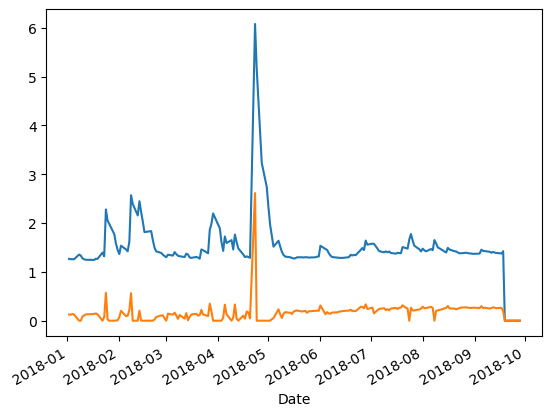

In [18]:
forecast_all["IBM_1_h_sigma"].plot()
forecast_all["IBM_1_h_omega"].plot()